<a href="https://colab.research.google.com/github/supernuper/6hw_git/blob/master/projectV4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Part 1 - Getting the dataset
  -------------------
  We will eventually have a folder named "MeGlass", with 2 subfolders "glasses" and no_glasses" for the labeled images.

In [3]:
# Imports
import os
import shutil
import gdown
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import numpy as np

In [ ]:
# Remove the folder and all its contents
# shutil.rmtree('/content/MeGlass')

In [2]:
# Define the URLs
dataset_url = 'https://drive.google.com/uc?id=1V0c8p6MOlSFY5R-Hu9LxYZYLXd8B8j9q'
labels_url = 'https://raw.githubusercontent.com/cleardusk/MeGlass/master/meta.txt'

# Define file names and directories
dataset_zip = 'MeGlass_120x120.zip'
labels_file = 'meta.txt'
base_dir = 'MeGlass'
glasses_dir = os.path.join(base_dir, 'glasses')
no_glasses_dir = os.path.join(base_dir, 'no_glasses')

In [4]:
# Download the dataset if not yet downloaded
if not os.path.exists(dataset_zip):
    print(f"Zip file {dataset_zip} not found. Downloading...")
    gdown.download(dataset_url, dataset_zip, quiet=False)
else:
    print(f"Dataset zip file {dataset_zip} already exists. Skipping download.")

# Download (if not already) the labels file
!if test -f meta.txt; then \
    echo "Labels file already exists."; \
else \
    wget -O meta.txt https://raw.githubusercontent.com/cleardusk/MeGlass/master/meta.txt && \
    echo "Labels file downloaded."; \
fi

# Check the labels
with open('meta.txt', 'r') as f:
    lines = f.readlines()
print("Number of labels:", len(lines))

Zip file MeGlass_120x120.zip not found. Downloading...


Downloading...
From (original): https://drive.google.com/uc?id=1V0c8p6MOlSFY5R-Hu9LxYZYLXd8B8j9q
From (redirected): https://drive.google.com/uc?id=1V0c8p6MOlSFY5R-Hu9LxYZYLXd8B8j9q&confirm=t&uuid=14db0f57-d485-4c37-88b3-1852f3b56fe1
To: /content/MeGlass_120x120.zip
100%|██████████| 352M/352M [00:10<00:00, 34.7MB/s]


--2024-08-10 08:51:54--  https://raw.githubusercontent.com/cleardusk/MeGlass/master/meta.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2063395 (2.0M) [text/plain]
Saving to: ‘meta.txt’

meta.txt            100%[===================>]   1.97M  --.-KB/s    in 0.008s  

2024-08-10 08:51:55 (239 MB/s) - ‘meta.txt’ saved [2063395/2063395]

Labels file downloaded.
Number of labels: 47917


In [5]:
# Unzip and the dataset
!unzip -j -q MeGlass_120x120.zip -d MeGlass

In [6]:
# Print size of MeGlass dataset
print("Size of MeGlass:", len(os.listdir('MeGlass')))

# Create directories for glasses and no glasses if they don't exist
os.makedirs(glasses_dir, exist_ok=True)
os.makedirs(no_glasses_dir, exist_ok=True)

# Split the dataset based on the labels
for line in lines:
    # Split the line into filename and label
    filename, label = line.strip().split()
    src_path = os.path.join(base_dir, filename)
    # Deliver to correct folder
    if label == '0':
        dest_path = os.path.join(no_glasses_dir, filename)
    else:
        dest_path = os.path.join(glasses_dir, filename)

    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)

# Verify the split
print("Images with glasses:", len(os.listdir(glasses_dir)))
print("Images without glasses:", len(os.listdir(no_glasses_dir)))

Size of MeGlass: 47917
Images with glasses: 14832
Images without glasses: 33085


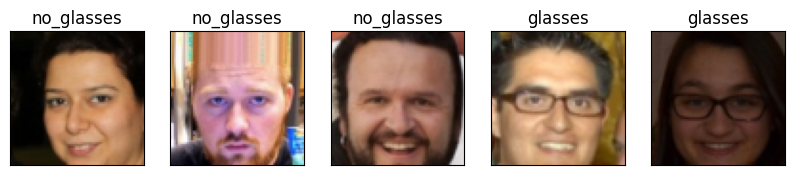

In [7]:
# Print images examples

# Define the conversion function for displaying images
def convert_to_imshow_format(image):
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])
    image = image * std[:, None, None] + mean[:, None, None] # Adjust to unnormalize
    image = image.clamp(0, 1).numpy()  # Convert to numpy array
    return image.transpose(1, 2, 0)   # Change the order to HWC

# Define the transformation (assuming normalization was used initially)
transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load the dataset
dataset = ImageFolder(root='MeGlass', transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

# Get a batch of images and labels
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Define class names (you may need to adjust this based on your dataset)
classes = dataset.classes

# Plot images
fig, axes = plt.subplots(1, len(images), figsize=(10, 2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

plt.show()

Part 2 - Splitting the dataset
  -------------------
  Split to train-valid-test

In [ ]:
# Function to split dataset
def split_dataset(dataset, train_ratio=0.80, val_ratio=0.10, test_ratio=0.10):
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    # Get all file names
    all_files = [os.path.basename(dataset.imgs[i][0]) for i in range(total_size)]

    # Sort file names for reproducibility
    all_files.sort()

    # Use a fixed random seed for reproducibility
    np.random.seed(80)

    # Shuffle the sorted file names
    np.random.shuffle(all_files)

    # Split the shuffled file names
    train_files = set(all_files[:train_size])
    val_files = set(all_files[train_size:train_size+val_size])
    test_files = set(all_files[train_size+val_size:])

    # Create indices for each split
    train_indices = [i for i in range(total_size) if os.path.basename(dataset.imgs[i][0]) in train_files]
    val_indices = [i for i in range(total_size) if os.path.basename(dataset.imgs[i][0]) in val_files]
    test_indices = [i for i in range(total_size) if os.path.basename(dataset.imgs[i][0]) in test_files]

    # Create subsets
    trainset = Subset(dataset, train_indices)
    valset = Subset(dataset, val_indices)
    testset = Subset(dataset, test_indices)

    return trainset, valset, testset

# Split the dataset
trainset, valset, testset = split_dataset(dataset)

print(f"Train set size: {len(trainset)}")
print(f"Validation set size: {len(valset)}")
print(f"Test set size: {len(testset)}")

# Create data loaders
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32, shuffle=False)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

Train set size: 40731
Validation set size: 2395
Test set size: 4791


Part 3 - The Model
------------------
We took DINOv2 architecture.

We changed the last layer from Identity to Linear.

At the first approach we only unfreeze the last layer.

At the second approach we unfreeze the last 2 layers.

We will then compare the results on the validation set, and choose the approach which provides better accuracy.

In [ ]:
# Import the pretrained dinov2 architecture
import torch
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


KeyboardInterrupt: 

In [ ]:
print(model)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [ ]:
# Modify the last layer of the model to Linear
model.head = torch.nn.Linear(1536, len(dataset.classes))
print(model)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [ ]:
# Functions for training the model and calculating accuracy

def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode, turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    return model_accuracy

import time

def train_model(model, train_loader, criterion, optimizer, scheduler, epochs, device):
    train_losses = []
    train_accuracies = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        epoch_time = time.time()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.data.item()

        running_loss /= len(train_loader)
        train_losses.append(running_loss)
        train_accuracy = calculate_accuracy(model, train_loader, device)
        train_accuracies.append(train_accuracy)
        scheduler.step()

        log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% ".format(epoch, running_loss, train_accuracy)
        epoch_time = time.time() - epoch_time
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)

    return train_losses, train_accuracies

In [ ]:
# Hyperparameters
batch_size = 1024
learning_rate = 0.001
epochs = 6
weight_decay = 1e-4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# First approach

#  Gather the parameters to be optimized/updated in this run.
#  We are doing feature extract method, so we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = []
print("Params to learn:")
for name, param in model.named_parameters():
    if "head" not in name: # Freeze all but last layer
        param.requires_grad = False
    else:
        param.requires_grad = True
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 head.weight
	 head.bias


In [ ]:
# DataLoaders
train_loader = DataLoader(trainset, batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size, shuffle=False)

Epoch: 1 | Loss: 0.2024 | Training accuracy: 97.805% Epoch Time: 1474.37 secs
Epoch: 2 | Loss: 0.0764 | Training accuracy: 98.458% Epoch Time: 1463.14 secs
Epoch: 3 | Loss: 0.0610 | Training accuracy: 98.630% Epoch Time: 1463.07 secs
Epoch: 4 | Loss: 0.0545 | Training accuracy: 98.721% Epoch Time: 1462.77 secs
Epoch: 5 | Loss: 0.0514 | Training accuracy: 98.760% Epoch Time: 1458.18 secs
Epoch: 6 | Loss: 0.0500 | Training accuracy: 98.763% Epoch Time: 1457.26 secs


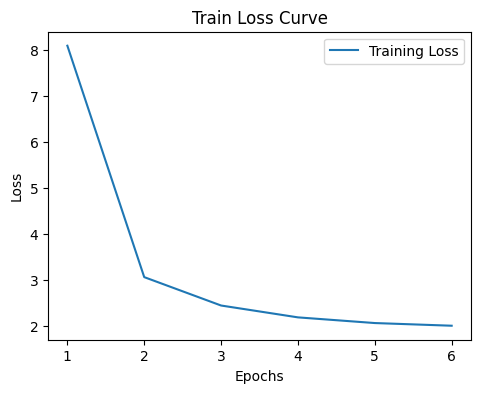

Validation accuracy for first approach: 98.914%


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses1, train_accuracies1 = train_model(model, train_loader, criterion, optimizer, scheduler, epochs, device)

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses1, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.legend()
plt.show()

val_accuracy_first_approach = calculate_accuracy(model, val_loader, device)
print("Validation accuracy for first approach: {:.3f}%".format(val_accuracy_first_approach))

In [ ]:
# Second approach
# Reload the model
model2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
# Modify the last layer of the model to Linear
model2.head = torch.nn.Linear(1536, len(dataset.classes))
print(model2)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [03:30<00:00, 21.6MB/s]


In [ ]:
#  Freezing all layers but the last two
for param in model.parameters():
    param.requires_grad = False

# Get all layer names
param_names = [name for name, _ in model.named_parameters()]
# Unfreeze the last two layers
for name in param_names[-4:]:
    param = dict(model.named_parameters())[name]
    param.requires_grad = True

# Check the correct parameters are unfreezed
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print(f"\t{name}: Trainable")

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses2, train_accuracies2 = train_model(model, train_loader, criterion, optimizer, scheduler, epochs, device)

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses2, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.legend()
plt.show()

val_accuracy_second_approach = calculate_accuracy(model, val_loader, device)
print("Validation accuracy for second approach: {:.3f}%".format(val_accuracy_second_approach))

In [ ]:
# Choosing the better approach
first_approach_better = False

if (val_accuracy_first_approach > val_accuracy_second_approach):
  first_approach_better = True
  print("First approach is better, feature extraction")
else:
  first_approach_better = False
  print("Second approach is better, fine tuning the last 2 layers")

Part 4 - Final Evaluation and Data Augmentations
------------------
Once we have the better approach, we want to combine the train and validation set and train the selected model on it, then display the results on the test set.

Then, we would use data augmentations using Kornia, to try and achieve better accuracy on the test set.

In [ ]:
# Combine train and validation set to one
trainset = ConcatDataset([trainset, valset])

# Verify the lengths of the datasets
print(f'Train set size: {len(trainset)}')
print(f'Test set size: {len(testset)}')

Train set size: 43126
Test set size: 4791


In [ ]:
# DataLoaders
train_loader = DataLoader(trainset, batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size, shuffle=False)

In [ ]:
# Reload the model
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
# Modify the last layer of the model to Linear
model.head = torch.nn.Linear(1536, len(dataset.classes))
print(model)

In [ ]:
# Choose better approach according to validation phase
params_to_update = []

if (first_approach_better):
  # First approach
  print("Params to learn:")
  for name, param in model.named_parameters():
    if "head" not in name: # Freeze all but last layer
        param.requires_grad = False
    else:
        param.requires_grad = True
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
else:
  # Second approach
  # Freezing all layers but the last two
  for param in model.parameters():
    param.requires_grad = False

  # Get all layer names
  param_names = [name for name, _ in model.named_parameters()]
  # Unfreeze the last two layers
  for name in param_names[-4:]:
    param = dict(model.named_parameters())[name]
    param.requires_grad = True

  # Check the correct parameters are unfreezed
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad:
      params_to_update.append(param)
      print(f"\t{name}: Trainable")

In [ ]:
# Hyperparameters
batch_size = 1024
learning_rate = 0.001
epochs = 6
weight_decay = 1e-4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = torch.nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
# Training the model
train_losses3, train_accuracies3 = train_model(model, train_loader, criterion, optimizer, scheduler, epochs, device)

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses3, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.legend()
plt.show()

test_accuracy_no_aug = calculate_accuracy(model, test_loader, device)
print("Test accuracy without augmentations: {:.3f}%".format(test_accuracy_no_aug))

In [ ]:
########################################
########################################
######      Data Augmentation    #######
########################################
########################################
!pip install kornia

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential

# Define a sequence of augmentations
aug_list = AugmentationSequential(
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.3),
    K.RandomAffine(360, [0.1, 0.1], [0.7, 1.2], [30., 50.], p=0.3),
    K.RandomPerspective(0.5, p=0.3),
    same_on_batch=False,
)

In [ ]:
# Reload the model
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
# Modify the last layer of the model to Linear
model.head = torch.nn.Linear(1536, len(dataset.classes))
print(model)

In [ ]:
# Hyperparameters
batch_size = 1024
learning_rate = 0.001
epochs = 6
weight_decay = 1e-4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = torch.nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
# Train with augmentations
train_losses = []
train_accuracies = []

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    epoch_time = time.time()

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = aug_list(inputs).to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.data.item()

    running_loss /= len(train_loader)
    train_losses.append(running_loss)
    train_accuracy = calculate_accuracy(model, train_loader, device)
    train_accuracies.append(train_accuracy)
    scheduler.step()

    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% ".format(epoch, running_loss, train_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.legend()
plt.show()

test_accuracy_with_aug = calculate_accuracy(model, test_loader, device)
print("Test accuracy with augmentations: {:.3f}%".format(test_accuracy_with_aug))